In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Library

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import seaborn as sns

# Directory and Data Setup


### Base directory

In [ ]:
base_dir = '/content/drive/MyDrive/Asyrof/Dataset'

###Define paths

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

###Data Verification

In [ ]:
for split_dir in [train_dir, val_dir, test_dir]:
    for class_dir in ['ripe', 'semi_ripe', 'unripe']:
        path = os.path.join(split_dir, class_dir)
        if not os.path.exists(path):
            print(f"Directory {path} does not exist.")
        else:
            print(f"Directory {path} contains {len(os.listdir(path))} images.")

Directory /content/drive/MyDrive/Asyrof/Dataset/train/ripe contains 56 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/train/semi_ripe contains 740 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/train/unripe contains 547 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/val/ripe contains 7 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/val/semi_ripe contains 93 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/val/unripe contains 68 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/test/ripe contains 8 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/test/semi_ripe contains 93 images.
Directory /content/drive/MyDrive/Asyrof/Dataset/test/unripe contains 69 images.


#Data Preparation

###Hyperparameters

In [ ]:
batch_size = 16
image_size = (224, 224)
learning_rate = 1e-4
epochs = 20

###Create image data generators with augmentation


In [ ]:
def create_data_generators(train_dir, test_dir, val_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.9, 1.1)
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    )
    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    )
    return train_generator, test_generator, validation_generator

train_generator, test_generator, validation_generator = create_data_generators(train_dir, test_dir, val_dir, image_size, batch_size)

Found 1343 images belonging to 3 classes.
Found 170 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


#Model Definition and Ensemble Approach

###Building the Ensemble Model

In [ ]:
def build_boosting_model(image_size):
    input_layer = tf.keras.layers.Input(shape=(image_size[0], image_size[1], 3))

    # Function to freeze a certain percentage of layers in a model
    def freeze_layers(model, freeze_percentage):
        total_layers = len(model.layers)
        layers_to_freeze = int(total_layers * freeze_percentage)
        for layer in model.layers[:layers_to_freeze]:
            layer.trainable = False
        return model

    # Model 1 (InceptionV3 Model)
    base_model_1 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(image_size[0], image_size[1], 3)
    )
    base_model_1 = freeze_layers(base_model_1, 0.5)  # Freeze 50% of layers
    x1 = base_model_1(input_layer, training=False)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

    # Model 2 (DenseNet201 Model)
    base_model_2 = tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=(image_size[0], image_size[1], 3)
    )
    base_model_2 = freeze_layers(base_model_2, 0.5)  # Freeze 50% of layers
    x2 = base_model_2(input_layer, training=False)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    # Model 3 (ResNet50V2 Model)
    base_model_3 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(image_size[0], image_size[1], 3)
    )
    base_model_3 = freeze_layers(base_model_3, 0.5)  # Freeze 50% of layers
    x3 = base_model_3(input_layer, training=False)
    x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)

    concatenated = tf.keras.layers.concatenate([x1, x2, x3])

    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output_layer = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Build the ensemble model with boosting idea
ensemble_model = build_boosting_model(image_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Boosting Inspired Ensemble Model Architecture:")
ensemble_model.summary()

Boosting Inspired Ensemble Model Architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_1[0][0]']             
                                                          4                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                               

#Training the Model

### Callbacks


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

### Calculate class weights to handle imbalance


In [ ]:
class_weights = {
    0: 1.0,  # ripe
    1: 1.0,  # semi_ripe
    2: 1.0   # unripe
}

### Adjusted class weights

In [ ]:
total_samples = sum([len(os.listdir(os.path.join(train_dir, cls))) for cls in ['ripe', 'semi_ripe', 'unripe']])
class_weights = {}
for cls in ['ripe', 'semi_ripe', 'unripe']:
    class_samples = len(os.listdir(os.path.join(train_dir, cls)))
    class_index = list(train_generator.class_indices.keys()).index(cls)
    class_weights[class_index] = total_samples / (3 * class_samples)

###Training

In [ ]:
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
83/83 [==============================] - 1795s 21s/step - loss: 1.1770 - accuracy: 0.4898 - val_loss: 3.8556 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 2/20
83/83 [==============================] - 1684s 20s/step - loss: 0.7791 - accuracy: 0.6127 - val_loss: 0.7571 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 3/20
83/83 [==============================] - 1586s 19s/step - loss: 0.6782 - accuracy: 0.6639 - val_loss: 4.7459 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 4/20
83/83 [==============================] - 1641s 20s/step - loss: 0.6938 - accuracy: 0.6639 - val_loss: 5.6030 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 5/20
83/83 [==============================] - 1589s 19s/step - loss: 0.6346 - accuracy: 0.6888 - val_loss: 3.8158 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 6/20
83/83 [==============================] - 1649s 20s/step - loss: 0.5092 - accuracy: 0.7408 - val_loss: 0.6875 - val_accuracy: 0.7125 - lr: 2.0000e-05
Epoch 7/20
83/83 [======================

#Model Evaluation and Visualization

###Evaluation

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')

train_loss, train_acc = best_model.evaluate(train_generator, steps=train_generator.samples // batch_size)
val_loss, val_acc = best_model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
test_loss, test_acc = best_model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Training Accuracy: {train_acc:.2f}, Training Loss: {train_loss:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}, Validation Loss: {val_loss:.2f}")
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

10/10 [==============================] - 86s 9s/step - loss: 0.3606 - accuracy: 0.8625
Training Accuracy: 0.91, Training Loss: 0.25
Validation Accuracy: 0.88, Validation Loss: 0.28
Test Accuracy: 0.86, Test Loss: 0.36


### Predictions Display

In [ ]:
def display_predictions(generator, model, class_indices, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img, label = generator.next()
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction[0])
        true_class = np.argmax(label[0])

        class_labels = list(class_indices.keys())

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0])
        plt.title(f"Pred: {class_labels[predicted_class]}\nTrue: {class_labels[true_class]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_generator, best_model, test_generator.class_indices, num_images=5)

1/1 [==============================] - 7s 7s/step


###Classification Based on Color

In [ ]:
def classify_mangosteen(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define thresholds for ripe, semi-ripe, and unripe colors
    ripe_lower = np.array([130, 50, 50])
    ripe_upper = np.array([180, 255, 255])

    semi_ripe_lower = np.array([90, 50, 50])
    semi_ripe_upper = np.array([130, 255, 255])

    unripe_lower = np.array([30, 50, 50])
    unripe_upper = np.array([90, 255, 255])

    # Create masks based on color thresholds
    mask_ripe = cv2.inRange(hsv_image, ripe_lower, ripe_upper)
    mask_semi_ripe = cv2.inRange(hsv_image, semi_ripe_lower, semi_ripe_upper)
    mask_unripe = cv2.inRange(hsv_image, unripe_lower, unripe_upper)

    # Count non-zero pixels in each mask
    count_ripe = cv2.countNonZero(mask_ripe)
    count_semi_ripe = cv2.countNonZero(mask_semi_ripe)
    count_unripe = cv2.countNonZero(mask_unripe)

    # Classify based on the mask with the highest number of non-zero pixels
    if count_ripe > count_semi_ripe and count_ripe > count_unripe:
        return "ripe"
    elif count_semi_ripe > count_ripe and count_semi_ripe > count_unripe:
        return "semi-ripe"
    else:
        return "unripe"

In [ ]:
def evaluate_color_classification(test_generator):
    ripe_images = []
    semi_ripe_images = []
    unripe_images = []

    for i in range(len(test_generator)):
        batch = test_generator[i]
        images, labels = batch[0], batch[1]

        for img in images:
            color_class = classify_mangosteen(img)

            if color_class == "ripe" and len(ripe_images) < 3:
                ripe_images.append(img)
            elif color_class == "semi-ripe" and len(semi_ripe_images) < 3:
                semi_ripe_images.append(img)
            elif color_class == "unripe" and len(unripe_images) < 3:
                unripe_images.append(img)

    return ripe_images, semi_ripe_images, unripe_images

### Make predictions on test set

In [ ]:
predictions = ensemble_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

11/11 [==============================] - 99s 8s/step


###Training History Plot

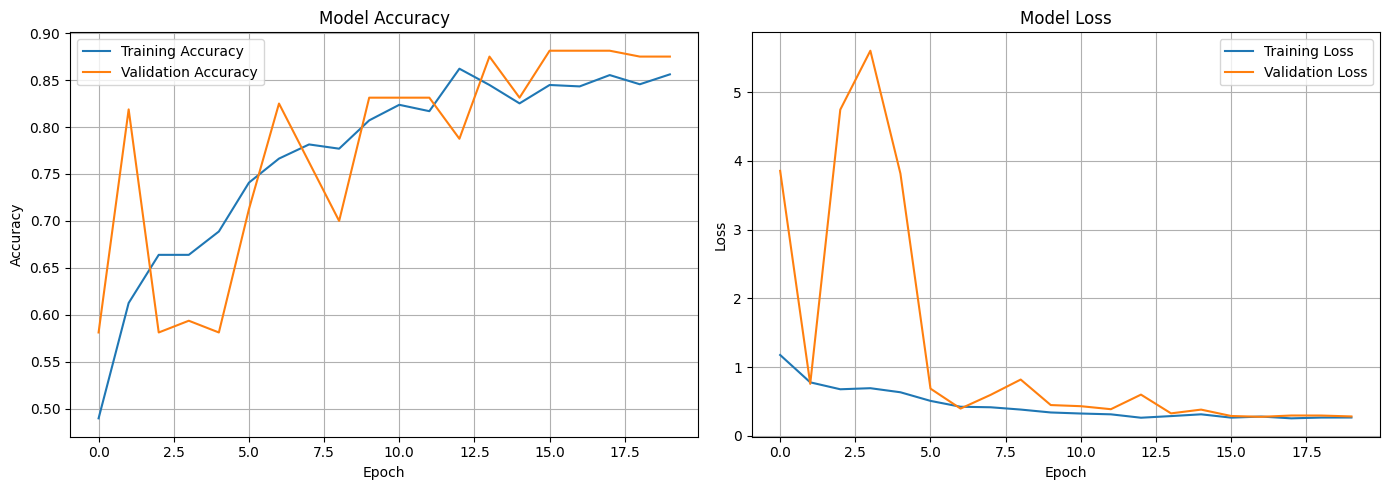

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

###Classification Report

In [ ]:
print("Classification Report:")
predictions = best_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Classification Report:
11/11 [==============================] - 95s 8s/step
              precision    recall  f1-score   support

        ripe       0.58      0.88      0.70         8
   semi_ripe       0.90      0.86      0.88        93
      unripe       0.87      0.87      0.87        69

    accuracy                           0.86       170
   macro avg       0.78      0.87      0.82       170
weighted avg       0.87      0.86      0.87       170



### Plot confusion matrix

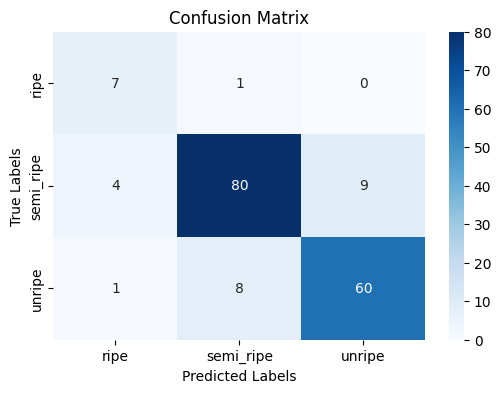

In [ ]:
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, target_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, list(test_generator.class_indices.keys()))

### Display sample images with predicted labels

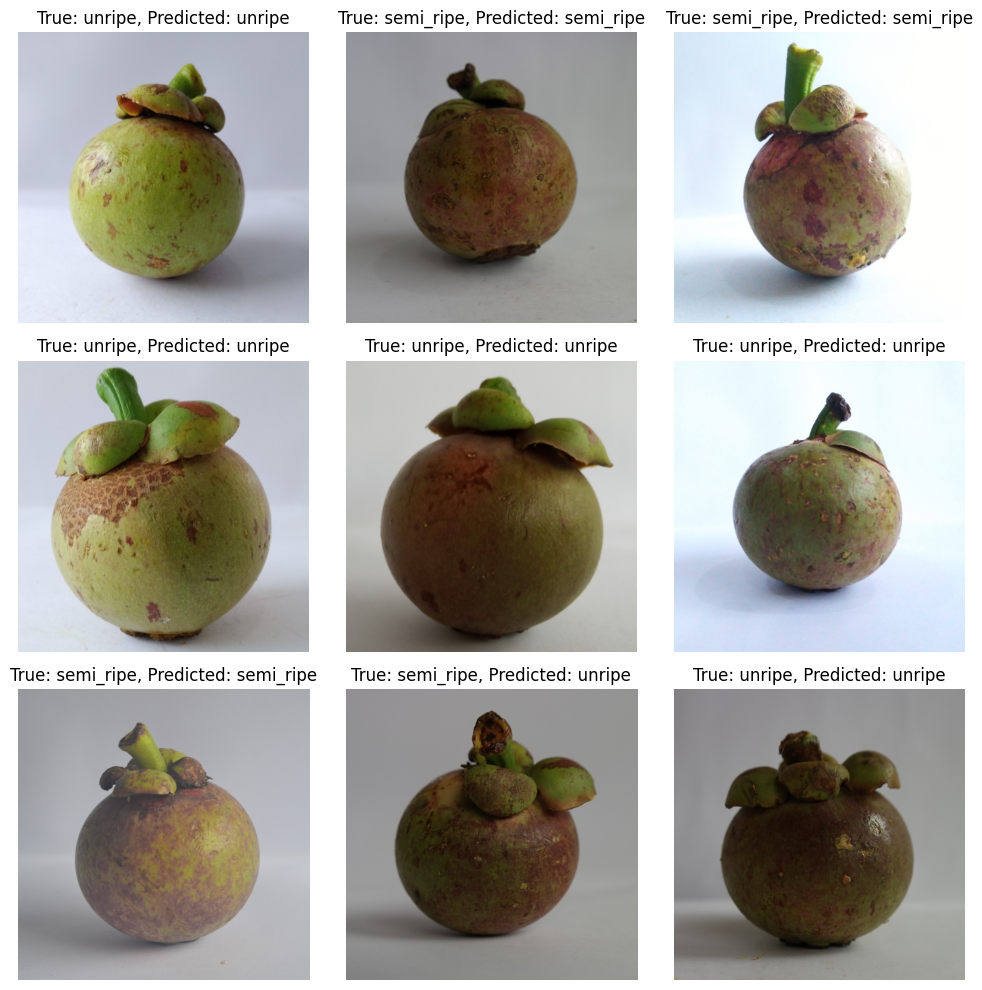

In [ ]:
def display_sample_images(test_generator, predictions, num_samples=9):
    sample_indexes = np.random.choice(len(test_generator.filenames), num_samples, replace=False)
    sample_images = []
    sample_labels = []
    predicted_labels = []

    for index in sample_indexes:
        image_path = os.path.join(test_dir, test_generator.filenames[index])
        image = plt.imread(image_path)
        label = test_generator.classes[index]
        prediction = np.argmax(predictions[index])
        sample_images.append(image)
        sample_labels.append(label)
        predicted_labels.append(prediction)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i, (image, label, prediction) in enumerate(zip(sample_images, sample_labels, predicted_labels)):
        axes[i].imshow(image)
        axes[i].set_title(f"True: {list(test_generator.class_indices.keys())[label]}, Predicted: {list(test_generator.class_indices.keys())[prediction]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(test_generator, predictions)

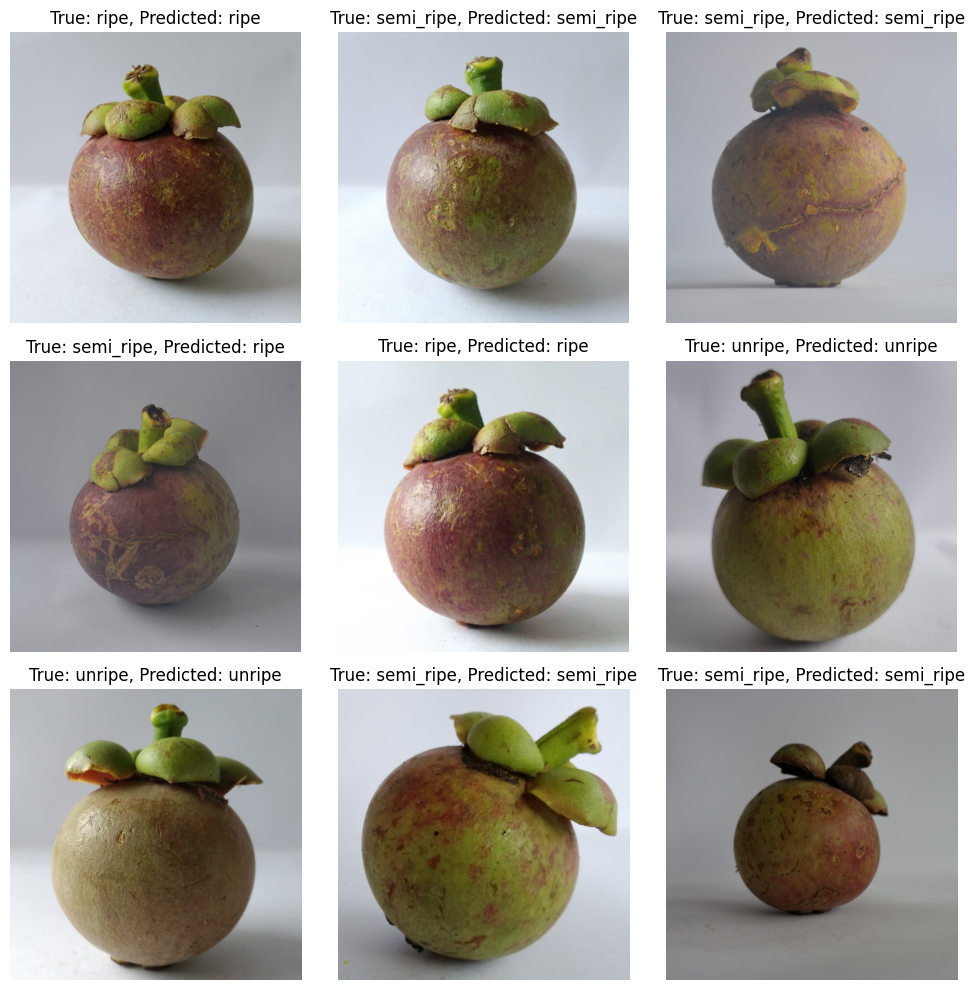

In [ ]:
display_sample_images(test_generator, predictions)